# BERT Cased with Interweaving Fine-Tuned Approach on Disability and Race

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.5 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 15.4 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFBertModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [2]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [3]:
MAX_SEQUENCE_LENGTH = 128

In [4]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

In [5]:
def build_bertcased_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained bertcased layers
    if num_train_layers == 0:
      bertcased_model.trainable = False

    # partially freeze the first n pre-trained bertcased layers
    else:
        for layer_num in range(num_train_layers):
            bertcased_model.bert.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertcased model instance
    bert_out = bertcased_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Race

In [6]:
# Disability
disability_train_df = pd.read_csv('drive/MyDrive/data/disability-dataset-train-augmented.csv')
disability_val_df = pd.read_csv('drive/MyDrive/data/disability-dataset-val-augmented.csv')
disability_test_df = pd.read_csv('drive/MyDrive/data/disability-dataset-test-augmented.csv')

X_disability_train, y_disability_train = to_arrays(disability_train_df)
X_disability_val, y_disability_val = to_arrays(disability_val_df)
X_disability_test, y_disability_test = to_arrays(disability_test_df)

# Race
# chunks are only for train and val
race_train_chunk1_df = pd.read_csv('drive/MyDrive/data/race-dataset-train-chunk1-augmented.csv')
race_val_chunk1_df = pd.read_csv('drive/MyDrive/data/race-dataset-val-chunk1-augmented.csv')
race_train_chunk2_df = pd.read_csv('drive/MyDrive/data/race-dataset-train-chunk2-augmented.csv')
race_val_chunk2_df = pd.read_csv('drive/MyDrive/data/race-dataset-val-chunk2-augmented.csv')

X_race_train_chunk1, y_race_train_chunk1 = to_arrays(race_train_chunk1_df)
X_race_val_chunk1, y_race_val_chunk1 = to_arrays(race_val_chunk1_df)

X_race_train_chunk2, y_race_train_chunk2 = to_arrays(race_train_chunk2_df)
X_race_val_chunk2, y_race_val_chunk2 = to_arrays(race_val_chunk2_df)

# single test set for race
race_test_df = pd.read_csv('drive/MyDrive/data/race-dataset-test-augmented.csv')
X_race_test, y_race_test = to_arrays(race_test_df)

In [7]:
X_disability_train[1]

' mental disability is extremely physical'

In [8]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [9]:
len(X_disability_train)

24904

In [10]:
X_race_train_chunk1[0]

' the narrative of african american men as criminals has historically been a tool used to justify their death'

In [11]:
X_race_train_chunk2[1]

'they are the ones with the most nappy-headed kids'

In [12]:
len(X_race_train_chunk2)

35014

## Load BERT Case Model from_pretrained()

In [13]:
bertcased_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bertcased_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
bertcased_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [15]:
# Takes 2 min to run
# Disability
bertcased_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertcased_tokenizer)
bertcased_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertcased_tokenizer)
bertcased_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertcased_tokenizer)

# Race Chunks
bertcased_race_train_chunk1_inputs = tokenizing_pipeline(X_race_train_chunk1, bertcased_tokenizer)
bertcased_race_val_chunk1_inputs = tokenizing_pipeline(X_race_val_chunk1, bertcased_tokenizer)

bertcased_race_train_chunk2_inputs = tokenizing_pipeline(X_race_train_chunk2, bertcased_tokenizer)
bertcased_race_val_chunk2_inputs = tokenizing_pipeline(X_race_val_chunk2, bertcased_tokenizer)

# Race Test
bertcased_race_test_inputs = tokenizing_pipeline(X_race_test, bertcased_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [16]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for race train set - chunk #1:

In [17]:
neg, pos = np.bincount(y_race_train_chunk1)
total = neg + pos
print('Race Train Chunk 1 Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

race_chunk1_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Race Train Chunk Weight for class 0: {:.2f}'.format(weight_for_0))
print('Race Train Chunk Weight for class 1: {:.2f}'.format(weight_for_1))

Race Train Chunk 1 Examples:
    Total: 35014
    Positive: 17775 (50.77% of total)

Race Train Chunk Weight for class 0: 1.02
Race Train Chunk Weight for class 1: 0.98


Get class weights for race train set - chunk #2:

In [18]:
neg, pos = np.bincount(y_race_train_chunk2)
total = neg + pos
print('Race Train Chunk 1 Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

race_chunk2_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Race Train Chunk Weight for class 0: {:.2f}'.format(weight_for_0))
print('Race Train Chunk Weight for class 1: {:.2f}'.format(weight_for_1))

Race Train Chunk 1 Examples:
    Total: 35014
    Positive: 17743 (50.67% of total)

Race Train Chunk Weight for class 0: 1.01
Race Train Chunk Weight for class 1: 0.99


In [19]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [20]:
disability_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Race Model

In [21]:
race_model = build_bertcased_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
race_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Race Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [22]:
disability_round1_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 97s 78ms/step - loss: 0.5889 - binary_accuracy: 0.6834 - precision: 0.6952 - recall: 0.7014 - f1_score: 0.6983 - val_loss: 0.4854 - val_binary_accuracy: 0.7664 - val_precision: 0.7717 - val_recall: 0.7803 - val_f1_score: 0.7760


# Round 2: Train Race Model on Chunk#1 for 1 epoch

In [23]:
race_round2_history = race_model.fit(bertcased_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertcased_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 134s 81ms/step - loss: 0.5613 - binary_accuracy: 0.7049 - precision_1: 0.7100 - recall_1: 0.7077 - f1_score: 0.7089 - val_loss: 0.4805 - val_binary_accuracy: 0.7748 - val_precision_1: 0.7830 - val_recall_1: 0.7746 - val_f1_score: 0.7788


# Round 3: Train Disability Model for 1 epoch

In [24]:
disability_round3_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4780 - binary_accuracy: 0.7718 - precision: 0.7866 - recall: 0.7728 - f1_score: 0.7797 - val_loss: 0.4543 - val_binary_accuracy: 0.7830 - val_precision: 0.8090 - val_recall: 0.7613 - val_f1_score: 0.7844


# Round 4: Train Race Model on Chunk#2 for 1 epoch

In [25]:
race_round4_history = race_model.fit(bertcased_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertcased_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.4803 - binary_accuracy: 0.7682 - precision_1: 0.7711 - recall_1: 0.7717 - f1_score: 0.7714 - val_loss: 0.4332 - val_binary_accuracy: 0.7915 - val_precision_1: 0.7882 - val_recall_1: 0.7960 - val_f1_score: 0.7921


# Round 5: Train Disability Model for 1 epoch

In [26]:
disability_round5_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4516 - binary_accuracy: 0.7882 - precision: 0.8050 - recall: 0.7846 - f1_score: 0.7947 - val_loss: 0.4354 - val_binary_accuracy: 0.7946 - val_precision: 0.8063 - val_recall: 0.7947 - val_f1_score: 0.8005


# Round 6: Train Race Model on Chunk#1 for 1 epoch

In [27]:
race_round6_history = race_model.fit(bertcased_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertcased_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 115s 78ms/step - loss: 0.4451 - binary_accuracy: 0.7911 - precision_1: 0.7950 - recall_1: 0.7929 - f1_score: 0.7940 - val_loss: 0.4290 - val_binary_accuracy: 0.7952 - val_precision_1: 0.8170 - val_recall_1: 0.7729 - val_f1_score: 0.7944



# Round 7: Train Disability Model for 1 epoch

In [28]:
disability_round7_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4346 - binary_accuracy: 0.7957 - precision: 0.8142 - recall: 0.7891 - f1_score: 0.8014 - val_loss: 0.4259 - val_binary_accuracy: 0.8003 - val_precision: 0.8149 - val_recall: 0.7956 - val_f1_score: 0.8052


## Checkpoint #1

In [29]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTCased_Disability_Race_Interwoven_disability-chkpt1-round-7.hdf5')

# Round 8: Train Race Model on Chunk#2 for 1 epoch

In [30]:
race_round8_history = race_model.fit(bertcased_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertcased_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.4334 - binary_accuracy: 0.7971 - precision_1: 0.8027 - recall_1: 0.7951 - f1_score: 0.7989 - val_loss: 0.4000 - val_binary_accuracy: 0.8105 - val_precision_1: 0.8038 - val_recall_1: 0.8204 - val_f1_score: 0.8120


# Round 9: Train Disability Model for 1 epoch

In [31]:
disability_round9_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4215 - binary_accuracy: 0.8038 - precision: 0.8233 - recall: 0.7949 - f1_score: 0.8089 - val_loss: 0.4207 - val_binary_accuracy: 0.8054 - val_precision: 0.8250 - val_recall: 0.7928 - val_f1_score: 0.8086


## Checkpoint #2

In [32]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTCased_Disability_Race_Interwoven_disability-chkpt2-round-9.hdf5')

# Round 10: Train Race Model on Chunk#1 for 1 epoch

In [33]:
race_round10_history = race_model.fit(bertcased_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertcased_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.4167 - binary_accuracy: 0.8061 - precision_1: 0.8109 - recall_1: 0.8060 - f1_score: 0.8085 - val_loss: 0.4064 - val_binary_accuracy: 0.8091 - val_precision_1: 0.8300 - val_recall_1: 0.7883 - val_f1_score: 0.8087


## Checkpoint #3

In [34]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTCased_Disability_Race_Interwoven_disability-chkpt3-round-9-10.hdf5')

# Round 11: Train Disability Model for 1 epoch

In [35]:
disability_round11_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4103 - binary_accuracy: 0.8110 - precision: 0.8303 - recall: 0.8020 - f1_score: 0.8159 - val_loss: 0.4164 - val_binary_accuracy: 0.8071 - val_precision: 0.8333 - val_recall: 0.7850 - val_f1_score: 0.8084


# Round 12: Train Race Model on Chunk#2 for 1 epoch

In [36]:
race_round12_history = race_model.fit(bertcased_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertcased_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.4088 - binary_accuracy: 0.8150 - precision_1: 0.8204 - recall_1: 0.8128 - f1_score: 0.8166 - val_loss: 0.3832 - val_binary_accuracy: 0.8215 - val_precision_1: 0.8198 - val_recall_1: 0.8231 - val_f1_score: 0.8215


# Round 13: Train Disability Model for 1 epoch

In [37]:
disability_round13_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.3992 - binary_accuracy: 0.8206 - precision: 0.8398 - recall: 0.8113 - f1_score: 0.8253 - val_loss: 0.4087 - val_binary_accuracy: 0.8109 - val_precision: 0.8236 - val_recall: 0.8086 - val_f1_score: 0.8160


# Round 14: Train Race Model on Chunk#1 for 1 epoch

In [38]:
race_round14_history = race_model.fit(bertcased_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertcased_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.3985 - binary_accuracy: 0.8174 - precision_1: 0.8236 - recall_1: 0.8148 - f1_score: 0.8192 - val_loss: 0.3913 - val_binary_accuracy: 0.8161 - val_precision_1: 0.8233 - val_recall_1: 0.8158 - val_f1_score: 0.8195


# Round 15: Train Disability Model for 1 epoch

In [39]:
disability_round15_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.3930 - binary_accuracy: 0.8226 - precision: 0.8429 - recall: 0.8116 - f1_score: 0.8269 - val_loss: 0.4064 - val_binary_accuracy: 0.8124 - val_precision: 0.8204 - val_recall: 0.8170 - val_f1_score: 0.8187


# Round 16: Train Race Model on Chunk#2 for 1 epoch

In [40]:
race_round16_history = race_model.fit(bertcased_race_train_chunk2_inputs,
                                          y_race_train_chunk2,
                                          validation_data=(bertcased_race_val_chunk2_inputs, y_race_val_chunk2),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk2_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.3935 - binary_accuracy: 0.8216 - precision_1: 0.8273 - recall_1: 0.8189 - f1_score: 0.8231 - val_loss: 0.3710 - val_binary_accuracy: 0.8292 - val_precision_1: 0.8269 - val_recall_1: 0.8317 - val_f1_score: 0.8293


## Checkpoint #4

In [41]:
race_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTCased_Disability_Race_Interwoven_race-chkpt4-round-16.hdf5')

# Round 17: Train Disability Model for 1 epoch

In [42]:
disability_round17_history = disability_model.fit(bertcased_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertcased_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.3877 - binary_accuracy: 0.8247 - precision: 0.8450 - recall: 0.8136 - f1_score: 0.8290 - val_loss: 0.4087 - val_binary_accuracy: 0.8189 - val_precision: 0.8412 - val_recall: 0.8021 - val_f1_score: 0.8212


# Round 18: Train Race Model on Chunk#1 for 1 epoch

In [43]:
race_round18_history = race_model.fit(bertcased_race_train_chunk1_inputs,
                                          y_race_train_chunk1,
                                          validation_data=(bertcased_race_val_chunk1_inputs, y_race_val_chunk1),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=race_chunk1_class_weight)

1459/1459 [==============================] - 114s 78ms/step - loss: 0.3811 - binary_accuracy: 0.8276 - precision_1: 0.8355 - recall_1: 0.8224 - f1_score: 0.8289 - val_loss: 0.3799 - val_binary_accuracy: 0.8220 - val_precision_1: 0.8319 - val_recall_1: 0.8171 - val_f1_score: 0.8245


# Plots for Disability Model

In [44]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

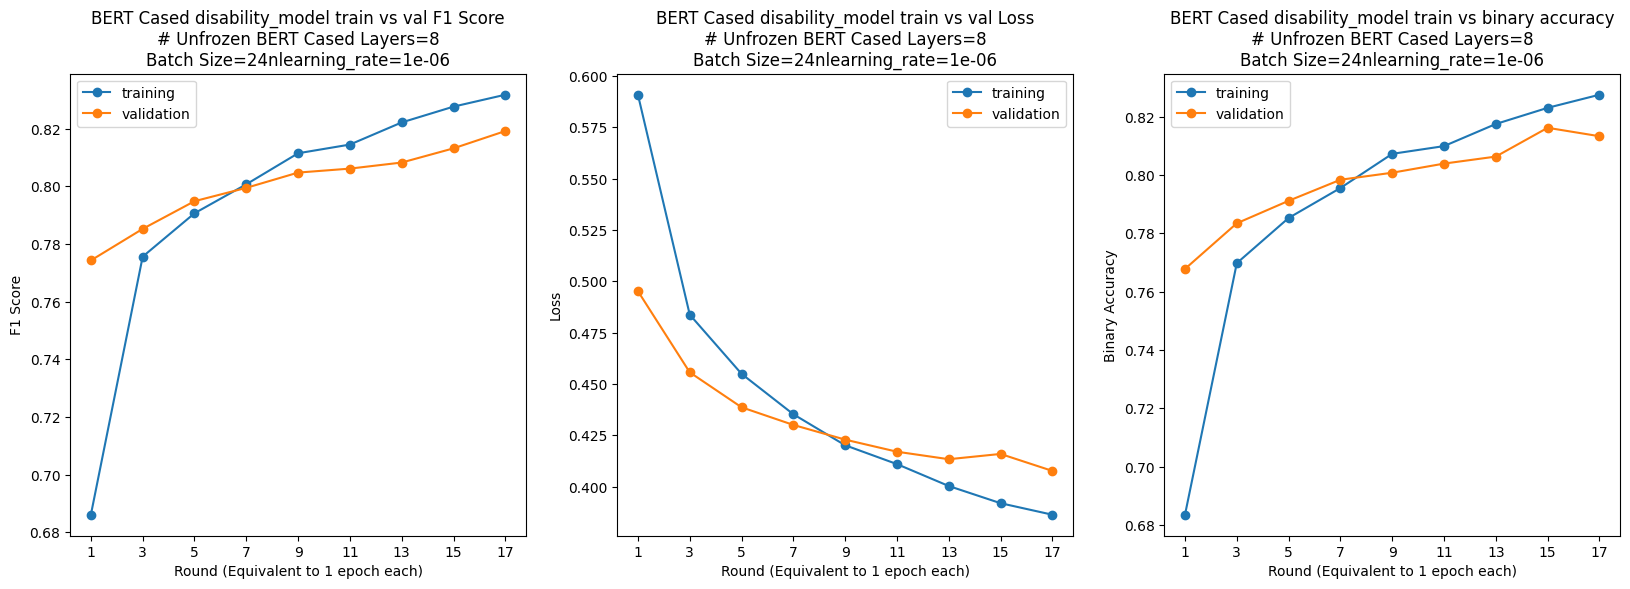

In [46]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERT Cased disability_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERT Cased disability_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERT Cased disability_model train vs binary accuracy\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Race Model

In [48]:
race_train_f1_scores = [race_round2_history.history['f1_score'][0][0],
                     race_round4_history.history['f1_score'][0][0],
                     race_round6_history.history['f1_score'][0][0],
                     race_round8_history.history['f1_score'][0][0],
                     race_round10_history.history['f1_score'][0][0],
                     race_round12_history.history['f1_score'][0][0],
                     race_round14_history.history['f1_score'][0][0],
                     race_round16_history.history['f1_score'][0][0],
                     race_round18_history.history['f1_score'][0][0]]
race_val_f1_scores = [race_round2_history.history['val_f1_score'][0][0],
                     race_round4_history.history['val_f1_score'][0][0],
                     race_round6_history.history['val_f1_score'][0][0],
                     race_round8_history.history['val_f1_score'][0][0],
                     race_round10_history.history['val_f1_score'][0][0],
                     race_round12_history.history['val_f1_score'][0][0],
                     race_round14_history.history['val_f1_score'][0][0],
                     race_round16_history.history['val_f1_score'][0][0],
                     race_round18_history.history['val_f1_score'][0][0]]
race_train_loss = [race_round2_history.history['loss'][0],
                     race_round4_history.history['loss'][0],
                     race_round6_history.history['loss'][0],
                     race_round8_history.history['loss'][0],
                     race_round10_history.history['loss'][0],
                     race_round12_history.history['loss'][0],
                     race_round14_history.history['loss'][0],
                     race_round16_history.history['loss'][0],
                     race_round18_history.history['loss'][0]]
race_val_loss = [race_round2_history.history['val_loss'][0],
                     race_round4_history.history['val_loss'][0],
                     race_round6_history.history['val_loss'][0],
                     race_round8_history.history['val_loss'][0],
                     race_round10_history.history['val_loss'][0],
                     race_round12_history.history['val_loss'][0],
                     race_round14_history.history['val_loss'][0],
                     race_round16_history.history['val_loss'][0],
                     race_round18_history.history['val_loss'][0]]
race_train_binary_accuracy = [race_round2_history.history['binary_accuracy'][0],
                     race_round4_history.history['binary_accuracy'][0],
                     race_round6_history.history['binary_accuracy'][0],
                     race_round8_history.history['binary_accuracy'][0],
                     race_round10_history.history['binary_accuracy'][0],
                     race_round12_history.history['binary_accuracy'][0],
                     race_round14_history.history['binary_accuracy'][0],
                     race_round16_history.history['binary_accuracy'][0],
                     race_round18_history.history['binary_accuracy'][0]]
race_val_binary_accuracy = [race_round2_history.history['val_binary_accuracy'][0],
                     race_round4_history.history['val_binary_accuracy'][0],
                     race_round6_history.history['val_binary_accuracy'][0],
                     race_round8_history.history['val_binary_accuracy'][0],
                     race_round10_history.history['val_binary_accuracy'][0],
                     race_round12_history.history['val_binary_accuracy'][0],
                     race_round14_history.history['val_binary_accuracy'][0],
                     race_round16_history.history['val_binary_accuracy'][0],
                     race_round18_history.history['val_binary_accuracy'][0]]


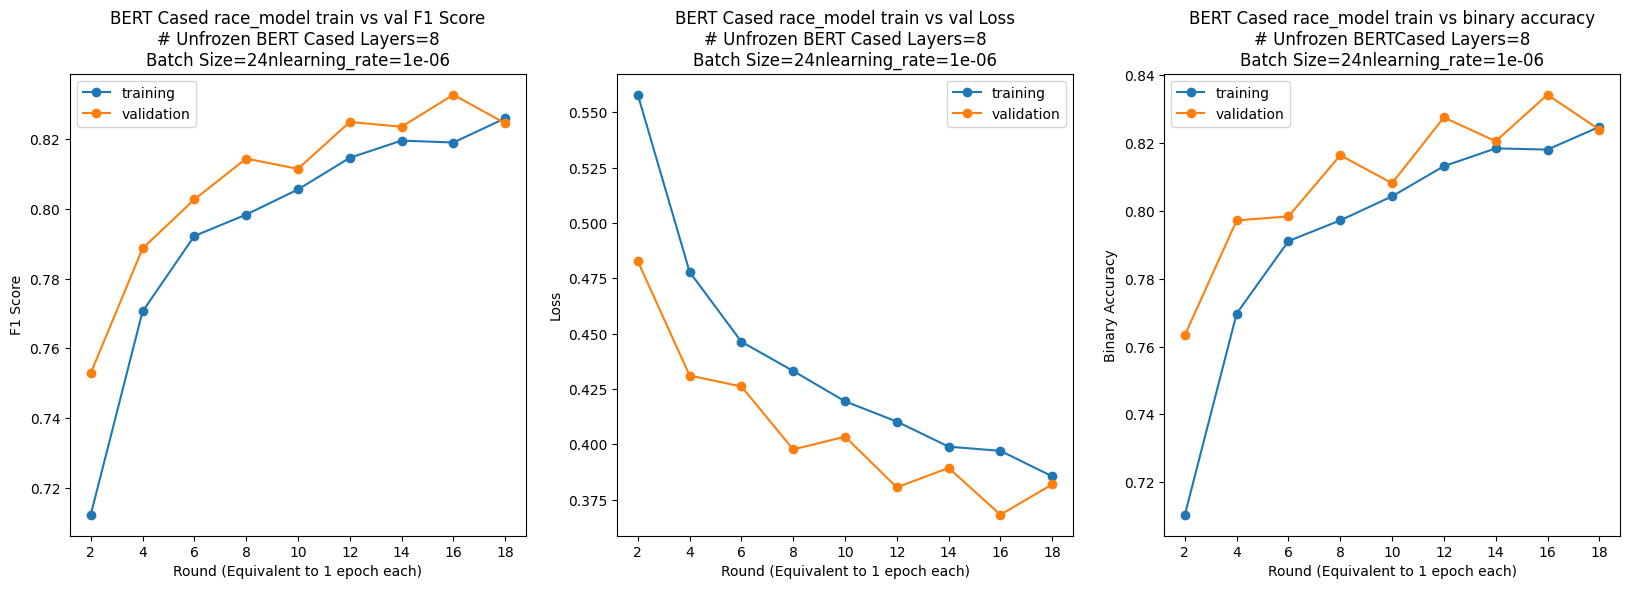

In [49]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(race_train_f1_scores, label="training", marker='o')
axis[0].plot(race_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERT Cased race_model train vs val F1 Score\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(race_train_loss, label="training", marker='o')
axis[1].plot(race_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERT Cased race_model train vs val Loss\n'+'# Unfrozen BERT Cased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(race_train_binary_accuracy, label="training", marker='o')
axis[2].plot(race_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERT Cased race_model train vs binary accuracy\n'+'# Unfrozen BERTCased Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Model Weights if Needed

In [44]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTCased_Disability_Race_Interwoven_disability_final.hdf5')
race_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTCased_Disability_Race_Interwoven_race_final.hdf5')

# Previous Results

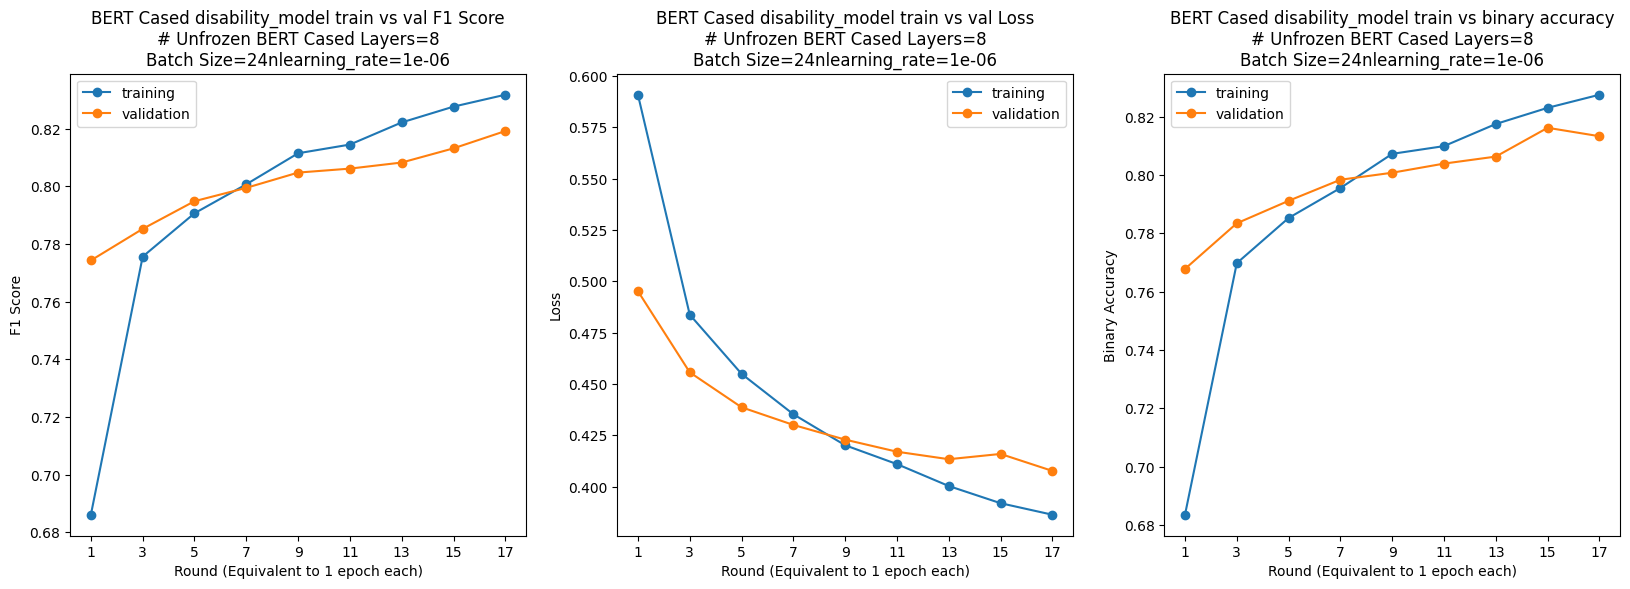

In [ ]:
# DISABILITY MODEL
# From the curves below, we'll keep the disability_model weights at round 7

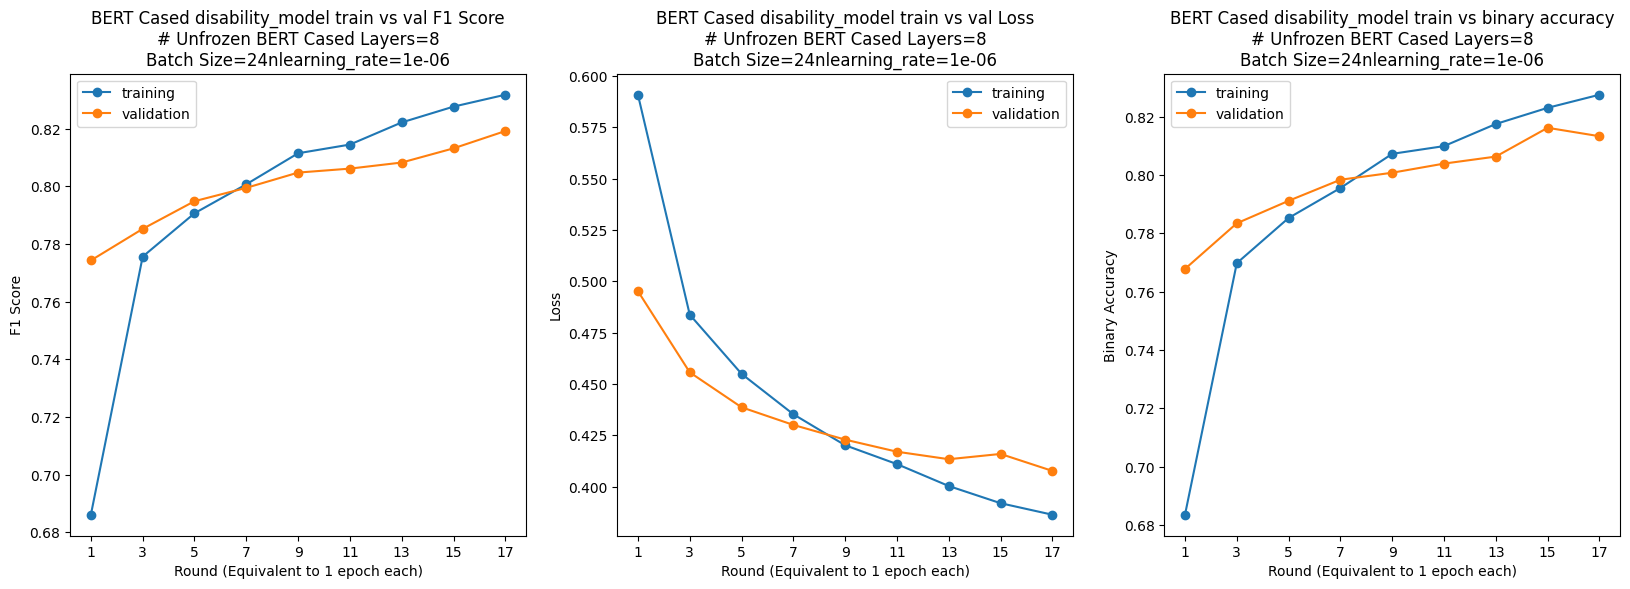

In [ ]:
# DISABILITY MODEL
# From the curves below, we'll keep the disability_model weights at either round 7, or 9

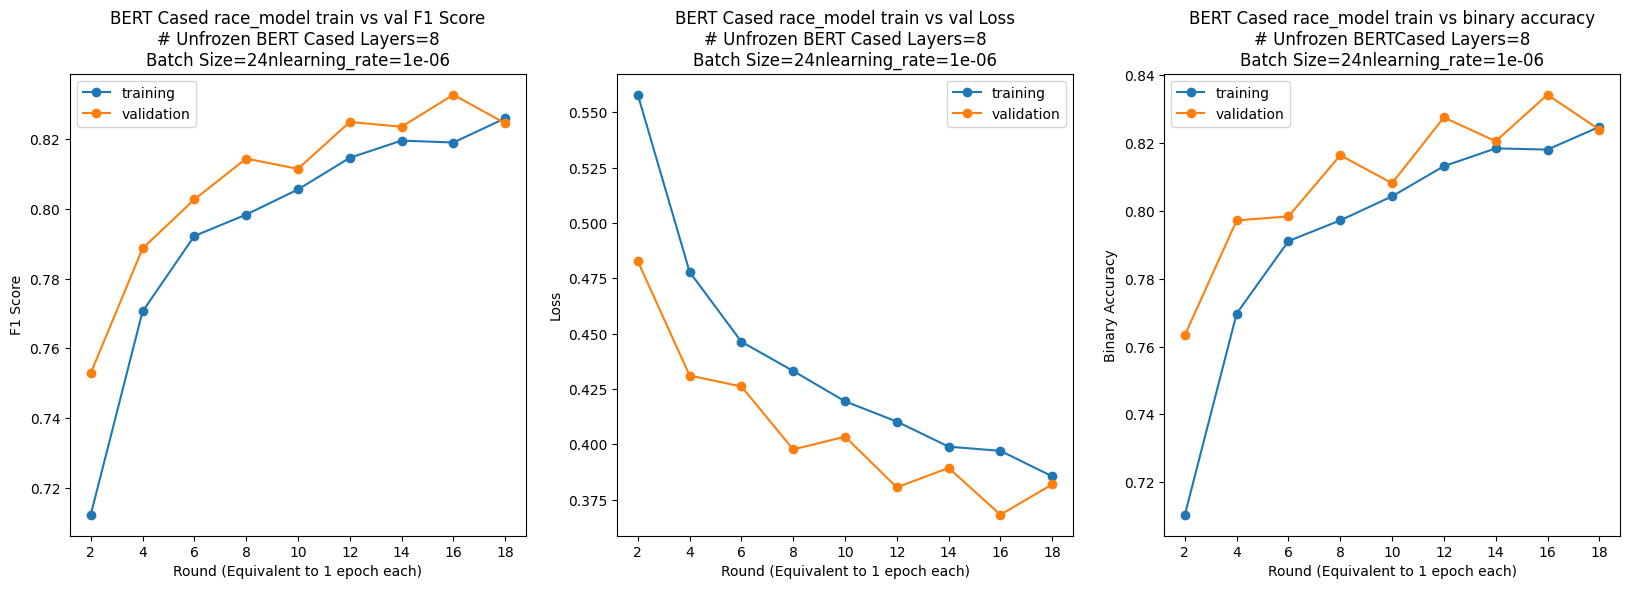

In [ ]:
# 5:00pm
# RACE MODEL
# From the curves below, we'll keep the race_model weights at the last round

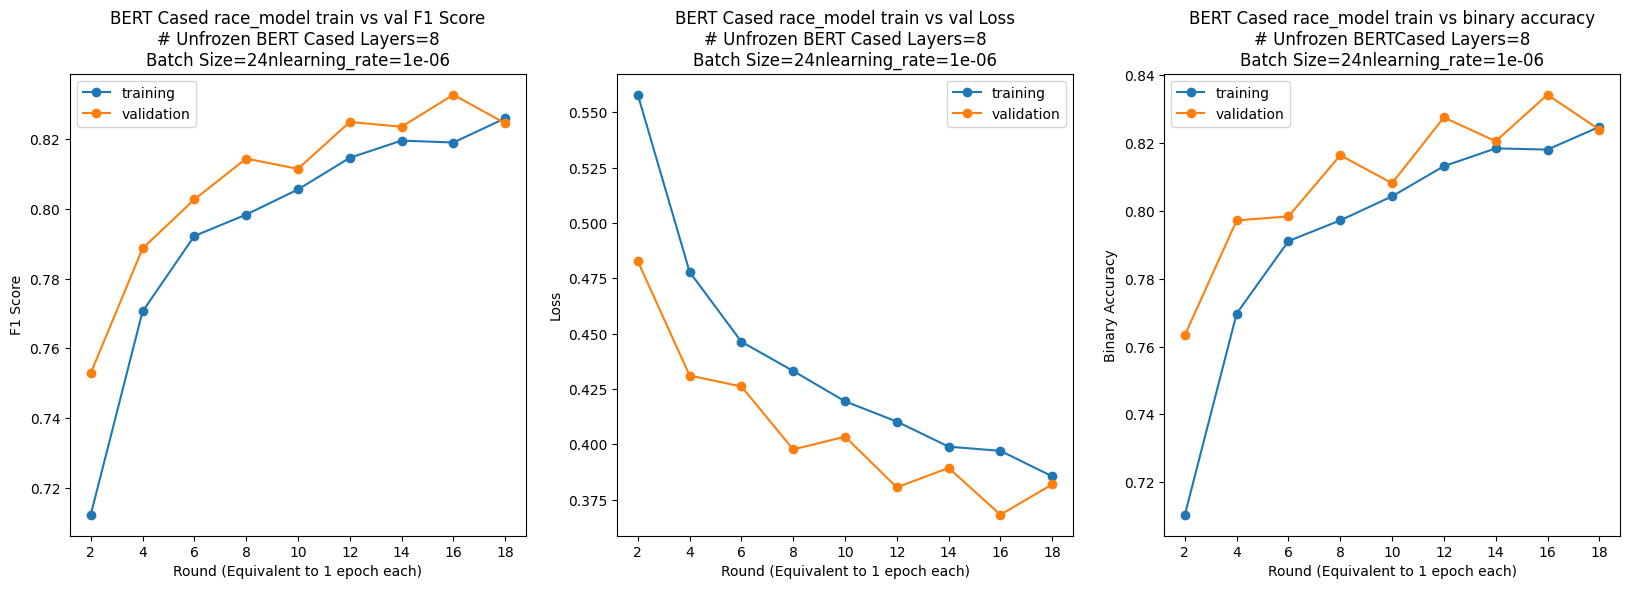

In [ ]:
# RACE MODEL
# From the curves below, we'll keep the race_model weights at the last round